In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (8.25, 6)

<h3>NOTES</h3>
<ul>
    <li>We may be able to extrapolate latitude and longitude to fill in the missing values based on the county they are in</li>
    <li>We may be able to fill in missing gaps for magnitude by manually looking them up</li> 
    <li>We looked for specific county spending on infrastructure but were not able to find anything</li>
    <li>For missing latitudes and longitudes, we looked at the county and derived it from there (we also assumed the ending latitude and longitude would be the same)</li>
    <li>These are all conditional models!</li>
    <li>ADD change in latitude/longitude</li>
</ul>
    
TODO:
<ul>
    <li>Compare with and without estimate property</li>
    <li>Split all in test and training and get accuracies and errors</li>
    <li>Make heatmap plots for wildfires and thunderstorms</li>
    <li>include change in wind direction (azimuth) and begin and end direction</li>
</ul>

<h2>1. Thunderstorms in Texas with no income</h2>

In [2]:
# Get the data
# column 1 = county name
# column 2 = begin location
# column 3 = begin date
# column 4 = begin time
# column 6 = magnitude
# column 10 = property damage
# column 11 = crops damage
# column 29 = end location
# column 30 = begin latitude
# column 31 = begin longitude
# column 32 = end latitude
# colunn 33 = end longitude

# load top 500 thunderstorms in texas from 1950 - 2018
data = pd.read_csv("texas_thunderstorm.csv", usecols=[1, 2, 3, 4, 6, 10, 11, 29, 30, 31, 32, 33])
data.info()

data = data.sample(frac=1)
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 12 columns):
CZ_NAME_STR            353 non-null object
BEGIN_LOCATION         353 non-null object
BEGIN_DATE             353 non-null object
BEGIN_TIME             353 non-null int64
MAGNITUDE              353 non-null float64
DAMAGE_PROPERTY_NUM    353 non-null int64
DAMAGE_CROPS_NUM       353 non-null int64
END_LOCATION           353 non-null object
BEGIN_LAT              353 non-null float64
BEGIN_LON              353 non-null float64
END_LAT                353 non-null float64
END_LON                353 non-null float64
dtypes: float64(5), int64(3), object(4)
memory usage: 33.2+ KB


,CZ_NAME_STR,BEGIN_LOCATION,BEGIN_DATE,BEGIN_TIME,MAGNITUDE,DAMAGE_PROPERTY_NUM,DAMAGE_CROPS_NUM,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON
322,HOUSTON CO.,GRAPELAND,5/3/09,512,65.0,200000,0,GRAPELAND,31.4900,-95.4800,31.4900,-95.4800
299,MOORE CO.,DUMAS,8/9/02,2227,61.0,200000,0,DUMAS,35.8500,-102.0300,35.8500,-101.9700
22,WEBB CO.,Laredo,9/26/93,1500,8.0,500000,0,,27.8200,-99.0100,27.8200,-99.0100
43,CHILDRESS CO.,CHILDRESS,6/15/08,1933,70.0,16000000,1000000,CHILDRESS,34.4347,-100.1630,34.4233,-100.2386
161,SMITH CO.,WINONA,4/3/07,2330,56.0,500000,0,WINONA,32.5000,-95.1700,32.5000,-95.1700
202,BELL CO.,LITTLE RIVER - ACADEMY,5/14/08,540,65.0,350000,0,ZABCIKVILLE,30.9800,-97.3700,31.0500,-97.1700
24,HEMPHILL CO.,Canadian,8/2/93,2045,70.0,500000,0,,35.9020,-100.3498,35.9020,-100.3498
11,RANDALL CO.,Amarillo,6/28/94,2117,59.0,500000,0,,34.9020,-101.7980,34.9020,-101.7980
108,BOWIE CO.,TEXARKANA,5/22/08,1615,87.0,1000000,0,TEXARKANA,33.4300,-94.0500,33.4300,-94.0500
348,HARRIS CO.,HOUSTON,3/31/07,530,59.0,195000,0,HOUSTON,29.7300,-95.3700,29.7300,-95.3700


<h3>1.1 Features and outcomes</h3>

In [3]:
# The outcomes
thunderstorm_outcomes = data.iloc[:, [5]]

list(thunderstorm_outcomes)

['DAMAGE_PROPERTY_NUM']

In [4]:
# The predictors
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE'], axis=1)

# NOTE: for right now crops damage is included, but we may want to see both with and without including this

list(thunderstorm_predictors)

['BEGIN_TIME',
 'MAGNITUDE',
 'DAMAGE_CROPS_NUM',
 'BEGIN_LAT',
 'BEGIN_LON',
 'END_LAT',
 'END_LON']

<h3>1.2 Preprocess features and outputs</h3>

In [5]:
def preprocess(thunderstorm_outcomes, thunderstorm_predictors):
    # Make the outcomes into a numpy array
    outcome_array = thunderstorm_outcomes.values.astype(np.float)

    # split into test and training data
    split_index = int(0.8 * len(outcome_array))
    outcome_array_train = outcome_array[:split_index, :]
    outcome_array_test = outcome_array[split_index:, :]
    print(outcome_array_train.shape)
    print('Shape of outcome array training', outcome_array_train.shape)
    print('Shape of outcome array test', outcome_array_test.shape)

    outcome_mean = np.mean(outcome_array)
    outcome_std = np.std(outcome_array)

    # normalize outcome
    outcome_array_train = (outcome_array_train - np.mean(outcome_array))/np.std(outcome_array)
    outcome_array_test = (outcome_array_test - np.mean(outcome_array))/np.std(outcome_array)

    # Make that numpy array into a torch Tensor
    outcome_Tensor_train = torch.from_numpy(outcome_array_train)
    outcome_Tensor_test = torch.from_numpy(outcome_array_test)

    # Make the predictors into a numpy array
    predictors_array = thunderstorm_predictors.values
    # NOTE: we took out any missing data values in the csv 

    # split into test and training data
    predictors_array_train = predictors_array[:split_index, :]
    predictors_array_test = predictors_array[split_index:, :]
    print('Shape of inputs array training', predictors_array_train.shape)
    print('Shape of inputs array test', predictors_array_test.shape)

    # Normalize inputs
    predictors_array_train = (predictors_array_train - np.mean(predictors_array, axis=0))/np.std(predictors_array, axis=0)
    predictors_array_test = (predictors_array_test - np.mean(predictors_array, axis=0))/np.std(predictors_array, axis=0)

    # Make that numpy array into a torch Tensor
    predictors_Tensor_train = torch.from_numpy(predictors_array_train.astype(np.float))
    predictors_Tensor_test = torch.from_numpy(predictors_array_test.astype(np.float))

    # Convert those DoubleTensors to FloatTensors
    # Chaning outcomes from a DoubleTensor to a FloatTensor
    outcome_Tensor_train = outcome_Tensor_train.float()
    outcome_Tensor_test = outcome_Tensor_test.float()

    # Changing the predictors too
    predictors_Tensor_train = predictors_Tensor_train.float()
    predictors_Tensor_test = predictors_Tensor_test.float()
    
    return (predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,
            outcome_Tensor_test, outcome_mean, outcome_std)

(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 7)
Shape of inputs array test (71, 7)


<h3>1.3 One Hidden Layer NN</h3>

In [7]:
class one_hidden_Net(torch.nn.Module):
    def __init__(self):
        super(one_hidden_Net, self).__init__()
        self.fc1 = torch.nn.Linear(7, 5)
        self.fc2 = torch.nn.Linear(5, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)
    
# Make it
one_hidden_model = one_hidden_Net()

In [8]:
# Define the loss function
loss_fn = torch.nn.MSELoss(size_average = False)

/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


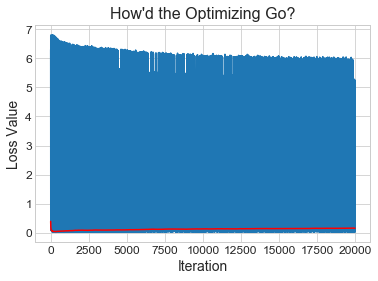

In [9]:
def train_neural_net(model, train_outcomes, train_inputs, test_outcomes, test_inputs):
    # Make an empty list to add to for each iteration
    current_loss_value_mini = []
    
    # For the cv too
    current_test_loss_value = []
    
    # Set the optimizer
    # originally step size was 1e-2
    optimizer = torch.optim.Adagrad(model.parameters(), lr = 1e-2)
    
    # Train the neural network
    for t in range(20000):
        # Get the current mini-batch indices
        indices = torch.randperm(len(train_inputs))[0:50]
        
        # Get the current mini-batches
        predictors_mini = train_inputs[indices]
        outcome_mini = train_outcomes[indices]
        
        # Get the current predictions
        current_pred_mini = model(predictors_mini)
        test_pred = model(test_inputs)
        
        # Compute current losses and and append that to the empty list
        current_loss_mini = loss_fn(current_pred_mini, outcome_mini)
        current_loss_value_mini.append(current_loss_mini.data.item())
        
        current_test_loss = loss_fn(test_pred, test_outcomes)
        current_test_loss_value.append(current_test_loss.data.item())
        
        # Zero the gradients before backwards pass
        optimizer.zero_grad()
        
        # Backwards pass
        current_loss_mini.backward()
        
        # Update model parameters
        optimizer.step()
        
    # Get iterations as a list for x-axis of plot
    iterations = list(range(0, 20000))
    
    # Convert total square error to mean square error
    mse = (np.asarray(current_loss_value_mini) / len(predictors_mini)).tolist()
    
    # For cv too
    mse_test = (np.asarray(current_test_loss_value) / len(test_inputs)).tolist()
    
    # Plot loss versus iteration
    plt.plot(iterations, mse)
    plt.plot(iterations, mse_test, "r-")
    plt.xlabel("Iteration", size = 14)
    plt.ylabel("Loss Value", size = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title("How'd the Optimizing Go?", size = 16)
    
train_neural_net(one_hidden_model, outcome_Tensor_train, predictors_Tensor_train, 
                 outcome_Tensor_test, predictors_Tensor_test)

In [10]:
def plot_train_perf(train_predictors, train_obs, model):
    
    # Plots how well the model performs on training data
    # train_predictors = the values that the model predicts from, PyTorch Tensor
    # train_obs = what the model would ideally predict, PyTorch Tensor
    # Returns a plot
    
    
    # Get the predictions
    train_predictors.requires_grad = False
    train_predictions = model(train_predictors)
    
    # Convert that to a numpy array
    train_predictions = train_predictions.data.numpy()
    
    # Put it in log-transformed scale and convert it to a list
    train_predictions = (train_predictions*np.log10(outcome_std) + np.log10(outcome_mean)).tolist()
    
    
    # Put the observed outcomes in log-transformed scale
    # and convert it to a list
    train_obs = (train_obs.numpy()*np.log10(outcome_std) + np.log10(outcome_mean)).tolist()
    
    
    # Plot it
    plt.scatter(train_obs, train_predictions, facecolors = "none", edgecolors = "k")
    axes = plt.gca()
    axes.set_xlim([2, 11])
    axes.set_ylim([2, 11])
#     axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.plot([2, 11], [2, 11], 'k-', lw = 2)
    axes.set_xlabel("Observed (Log-Transformed US Dollars)", size = 14)
    axes.set_ylabel("Predicted (Log-Transformed US Dollars)", size = 14)
    axes.set_title("Model Performance on Training Data", size = 16)

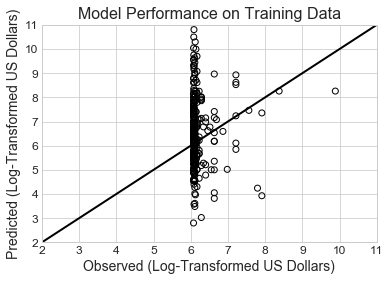

In [11]:
plot_train_perf(predictors_Tensor_train, outcome_Tensor_train, one_hidden_model)

In [12]:
def compute_MSE(predictors, observed_outcomes, model):
    
    # Computes the mean squared error of the model
    # predictors = the variables and values used in prediction
    # observed_outcomes = what the prediction would ideally yield
    # Returns a PyTorch Variable
    
    
    # Get the validation set predictions
    predictors.requires_grad = False
    predictions = model(predictors)
    
    # Get the validation set outcomes
    outcomes = observed_outcomes
    
    # Get the loss - (total) residual sum of squares
    total_SE = loss_fn(predictions, outcomes)
    
    # Average that to get mean square error
    mean_SE = total_SE / len(predictors)
    return(mean_SE)

In [13]:
MSE = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, one_hidden_model)
MSE

tensor(0.1583, grad_fn=<DivBackward0>)

<h3>1.4 Two hidden layer NN</h3>

In [14]:
class two_hidden_Net(torch.nn.Module):
    def __init__(self):
        super(two_hidden_Net, self).__init__()
        self.fc1 = torch.nn.Linear(7, 5)
        self.fc2 = torch.nn.Linear(5, 3)
        self.fc3 = torch.nn.Linear(3, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return(x)
    
# Make it
two_hidden_model = two_hidden_Net()

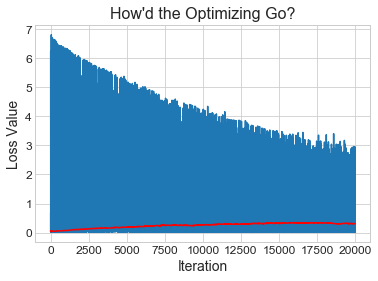

In [15]:
train_neural_net(two_hidden_model, outcome_Tensor_train, predictors_Tensor_train,
                outcome_Tensor_test, predictors_Tensor_test)

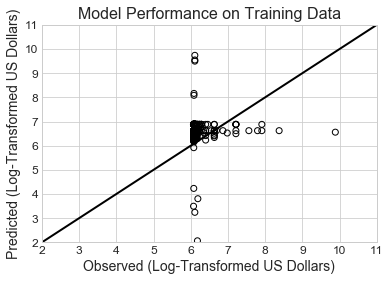

In [16]:
plot_train_perf(predictors_Tensor_train, outcome_Tensor_train, two_hidden_model)

In [17]:
MSE = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, two_hidden_model)
MSE

tensor(0.3057, grad_fn=<DivBackward0>)

<h3>1.5 Our own Deep Neural Net</h3>

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(7, 6)
        self.fc2 = torch.nn.Linear(6, 5)
        self.fc3 = torch.nn.Linear(5, 4)
        self.fc4 = torch.nn.Linear(4, 3)
        self.fc5 = torch.nn.Linear(3, 2)
        self.fc6 = torch.nn.Linear(2, 1)
    
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = torch.nn.functional.relu(self.fc4(x))
        x = torch.nn.functional.relu(self.fc5(x))
        x = self.fc6(x)
        return(x)
    
# Make it
multi_hidden_model = Net()

In [ ]:
train_neural_net(multi_hidden_model, outcome_Tensor_train, predictors_Tensor_train,
                outcome_Tensor_test, predictors_Tensor_test)

In [ ]:
plot_train_perf(predictors_Tensor_train, outcome_Tensor_train, multi_hidden_model)

In [ ]:
MSE = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, multi_hidden_model)
MSE

<h3>A note on the MSE ...</h3>
    
It seems that whenever we retrain the model, the MSE is slightly different, but can sometimes be very bad (occasionally). The current plan therefore is to pick the model with the best MSE and save it's weights and biases. 

(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 7)
Shape of inputs array test (71, 7)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 7)
Shape of inputs array test (71, 7)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 7)
Shape of inputs array test (71, 7)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 7)
Shape of inputs array test (71, 7)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 7)
Shape of inputs array test (71, 7)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 7)
Shape of inputs array test (71, 7)
(282, 1)
Shape of outcome array tr

(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 7)
Shape of inputs array test (71, 7)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 7)
Shape of inputs array test (71, 7)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 7)
Shape of inputs array test (71, 7)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 7)
Shape of inputs array test (71, 7)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 7)
Shape of inputs array test (71, 7)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 7)
Shape of inputs array test (71, 7)
(282, 1)
Shape of outcome array tr

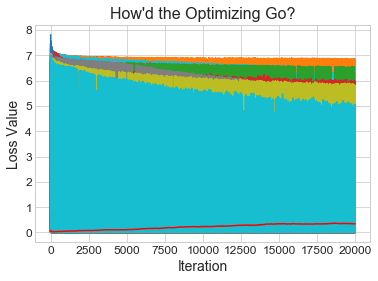

In [20]:
best_model = None
best_mse = 10
for i in range(100):
    data = data.sample(frac=1)
    thunderstorm_outcomes = data.iloc[:, [5]]
    thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE'], axis=1)
    (predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)
    
    # define our nets
    one_hidden_model = one_hidden_Net()
    two_hidden_model = two_hidden_Net()
    
    # Train one layer
    train_neural_net(one_hidden_model, outcome_Tensor_train, predictors_Tensor_train,
                outcome_Tensor_test, predictors_Tensor_test)
    # Train two layer
    train_neural_net(two_hidden_model, outcome_Tensor_train, predictors_Tensor_train,
                outcome_Tensor_test, predictors_Tensor_test)
    
    one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, one_hidden_model).item()
    two_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, two_hidden_model).item()
    
    if (one_layer_mse < best_mse):
        best_model = one_hidden_model
        best_mse = one_layer_mse
    if (two_layer_mse < best_mse):
        best_model = two_hidden_model
        best_mse = two_layer_mse
        
print(best_model)
print(best_mse)
        
                                
    

From the results above, we can conclude a two layer network works best giving an mse of 0.01177